In [1]:
#import libraries

import pandas as pd
from pandas import concat
#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import models, layers
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

from numpy import concatenate
from math import sqrt

In [2]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
	'''
	Convert series
	Returns:
	dataframe ready for supervised learning
	
	'''
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	agg = concat(cols, axis=1)
	agg.columns = names

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace = True)
	return agg

In [3]:
# load dataset
dataset = pd.read_csv('Resampled_PF.csv', index_col = 0)
dataset = dataset.drop(['Date'], axis = 1)
values = dataset.values
values = values.astype('float64')

# normalize features
scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning dataset
#reframed = series_to_supervised(scaled, 1, 2)
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis = 1, inplace = True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.848168   0.330645   0.000000  0.942408
2   0.942408   0.362903   0.300214  0.958115
3   0.958115   0.387097   0.600427  0.942408
4   0.942408   0.564516   0.600427  0.958115
5   0.958115   0.400538   0.600427  0.958115


In [4]:
# split into train and test sets
values = reframed.values
n_train_hours = 240 * 24 #8months hourly data
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) #more hours (~5k) for training

(5760, 1, 3) (5760,) (852, 1, 3) (852,)


Train on 5760 samples, validate on 852 samples
Epoch 1/100
5760/5760 - 4s - loss: 0.9606 - val_loss: 0.9475
Epoch 2/100
5760/5760 - 0s - loss: 0.9079 - val_loss: 0.8966
Epoch 3/100
5760/5760 - 0s - loss: 0.8548 - val_loss: 0.8447
Epoch 4/100
5760/5760 - 0s - loss: 0.8003 - val_loss: 0.7909
Epoch 5/100
5760/5760 - 0s - loss: 0.7436 - val_loss: 0.7345
Epoch 6/100
5760/5760 - 0s - loss: 0.6837 - val_loss: 0.6745
Epoch 7/100
5760/5760 - 0s - loss: 0.6198 - val_loss: 0.6101
Epoch 8/100
5760/5760 - 0s - loss: 0.5508 - val_loss: 0.5403
Epoch 9/100
5760/5760 - 0s - loss: 0.4760 - val_loss: 0.4643
Epoch 10/100
5760/5760 - 0s - loss: 0.3945 - val_loss: 0.3814
Epoch 11/100
5760/5760 - 0s - loss: 0.3058 - val_loss: 0.2909
Epoch 12/100
5760/5760 - 0s - loss: 0.2098 - val_loss: 0.1925
Epoch 13/100
5760/5760 - 0s - loss: 0.1131 - val_loss: 0.0932
Epoch 14/100
5760/5760 - 0s - loss: 0.0575 - val_loss: 0.0496
Epoch 15/100
5760/5760 - 0s - loss: 0.0734 - val_loss: 0.0552
Epoch 16/100
5760/5760 - 0s - lo

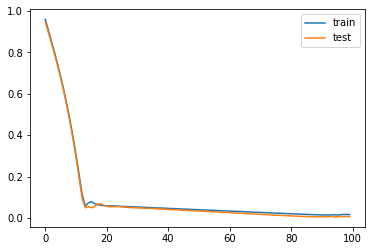

In [5]:
# design network: 50 neurons in the first hidden layer and 1 neuron in the output layer for prediction of power factor 
## line 1 (1 timestep with 3 features)

model = models.Sequential()
model.add(layers.LSTM(50, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss = 'mae', optimizer = 'adam') #MAE and adam version of SGD

# fit network
#history = model.fit(train_X, train_y, epochs = 50, batch_size = 72, validation_data = (test_X, test_y), verbose = 2, shuffle = False)
history = model.fit(train_X, train_y, epochs = 100, batch_size = 1000, validation_data = (test_X, test_y), verbose = 2, shuffle = False)

# plot history
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'test')
pyplot.legend()
pyplot.show()

In [6]:
##test loss if drops below training loss, the model may be overfitting the training data.


# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis = 1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.002
